#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.
 
### CHAPTER 12
**CH12B Electricity consumption and temperature**

case-shiller-la dataset

version 1.0 2021-05-31
 
 

In [1]:
import os
import sys
import warnings

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from plotnine import *
from mizani.formatters import date_format
from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")


In [2]:
current_path = os.getcwd()
base_dir = current_path.split("da_case_studies")[0]

data_in = os.path.join(str(base_dir), "da_data_repo/arizona-electricity/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/")
output = os.path.join(
    str(base_dir), "da_case_studies/ch12-electrictiy-temperature/output/"
)
func = os.path.join(str(base_dir), "da_case_studies/ch00-tech-prep/")

sys.path.append(func)


In [3]:
from py_helper_functions import *


In [4]:
electricity = pd.read_csv(os.path.join(data_in, "electricity_resid_AZ.csv"))
#electricity = pd.read_csv("https://osf.io/download/wbef4/")



In [5]:
electricity.head()


,MY,Q
0,Jan-01,2063
1,Feb-01,1790
2,Mar-01,1690
3,Apr-01,1404
4,May-01,1984


In [6]:
electricity["date"] = pd.to_datetime(electricity["MY"], format="%b-%y")

electricity["year"] = electricity["date"].dt.year
electricity["month"] = electricity["date"].dt.month
electricity["ym"] = (
    electricity["year"].astype(str).str.cat(electricity["month"].astype(str), sep="m")
)

electricity = electricity[["Q", "date", "ym"]]

electricity["lnQ"] = electricity["Q"].map(np.log)


In [7]:
electricity.head()


,Q,date,ym,lnQ
0,2063,2001-01-01,2001m1,7.631917
1,1790,2001-02-01,2001m2,7.489971
2,1690,2001-03-01,2001m3,7.432484
3,1404,2001-04-01,2001m4,7.247081
4,1984,2001-05-01,2001m5,7.592870


In [8]:
climate = pd.read_csv(os.path.join(data_in, "climate_Phoenix_AZ.csv"))


In [9]:
climate.head()


,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283


In [10]:
climate["tempdate"] = pd.to_datetime(climate["DATE"], format="%Y-%m")

climate["year"] = climate["tempdate"].dt.year
climate["month"] = climate["tempdate"].dt.month
climate["ym"] = (
    climate["year"].astype(str).str.cat(climate["month"].astype(str), sep="m")
)

climate["ndays"] = 30
climate.loc[climate["month"].isin([1, 3, 5, 7, 8, 10, 12]), "ndays"] = 31
climate.loc[climate["month"] == 2, "ndays"] = 28

for x in ["CLDD", "HTDD", "DX70", "DX90"]:
    climate[x + "_avg"] = climate[x] / climate["ndays"]

climate = climate.drop(columns=["DATE", "tempdate", "STATION", "NAME"])


In [11]:
climate.head()


,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,676,0,30,28,0,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,425,0,31,24,0,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,98,0,26,0,70,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,0,0,14,0,353,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,0,0,6,0,283,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [12]:
climate[["CLDD_avg", "HTDD_avg", "DX70_avg", "DX90_avg"]].describe()


,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
count,332.000000,332.000000,332.000000,332.000000
mean,12.698136,2.422917,0.822810,0.468293
std,11.576086,3.525208,0.257170,0.431420
min,0.000000,0.000000,0.107143,0.000000
25%,0.666667,0.000000,0.694643,0.000000
50%,10.163441,0.131183,1.000000,0.393548
75%,24.900000,4.120680,1.000000,0.967742
max,33.290323,12.129032,1.000000,1.000000


In [13]:
data = pd.merge(climate, electricity, on="ym", how="inner")


In [14]:
data = data[(data["year"] >= 2001) & (data["year"] <= 2017)].reset_index(drop=True)


In [15]:
data.loc[data["Q"].notnull(), ["year", "month"]].describe()


,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [16]:
data.loc[data["CLDD"].notnull(), ["year", "month"]].describe()


,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [17]:
data[["Q", "lnQ", "CLDD_avg", "HTDD_avg"]].describe()


,Q,lnQ,CLDD_avg,HTDD_avg
count,204.000000,204.000000,204.000000,204.000000
mean,2636.392157,7.827744,13.317995,2.283919
std,864.697489,0.309525,11.779998,3.499287
min,1404.000000,7.247081,0.000000,0.000000
25%,1938.250000,7.569541,1.104551,0.000000
50%,2338.500000,7.757263,10.333333,0.016667
75%,3309.750000,8.104615,25.875000,3.737500
max,4674.000000,8.449771,33.290323,12.096774


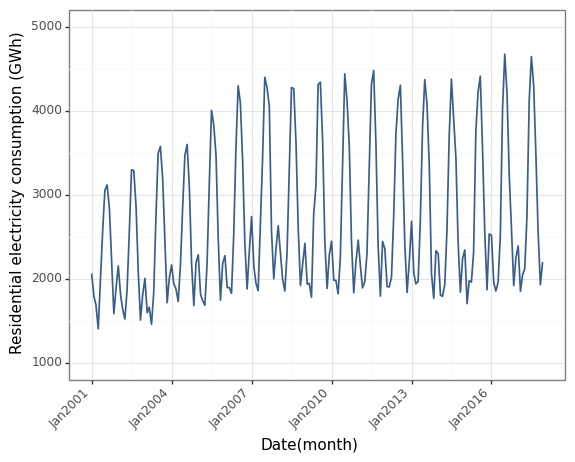

<ggplot: (364415732)>

In [18]:
g1 = (
    ggplot(data=data)
    + geom_line(aes(x="date", y="Q"), colour=color[0], size=0.7)
    + labs(x="Date(month)", y="Residential electricity consumption (GWh)")
    + scale_y_continuous(limits=[1000, 5000], breaks=seq(1000, 5001, 1000))
    + scale_x_date(
        breaks=[
            "2001-01-01",
            "2004-01-01",
            "2007-01-01",
            "2010-01-01",
            "2013-01-01",
            "2016-01-01",
        ],
        labels=date_format("%b%Y"),
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1


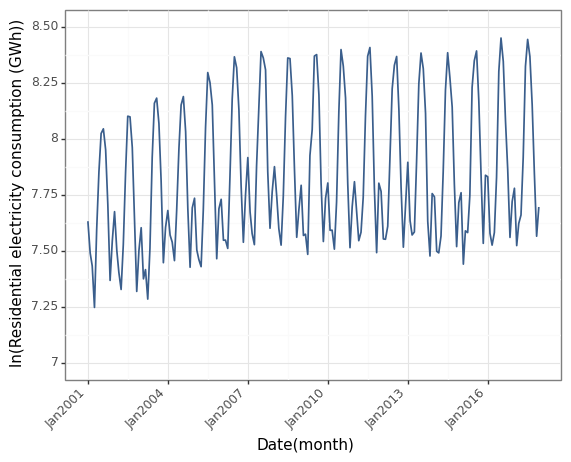

<ggplot: (364609789)>

In [19]:
g1 = (
    ggplot(data=data)
    + geom_line(aes(x="date", y="lnQ"), colour=color[0], size=0.7)
    + labs(x="Date(month)", y="ln(Residential electricity consumption (GWh))")
    + scale_y_continuous(limits=[7, 8.5], breaks=seq(7, 8.51, 0.25))
    + scale_x_date(
        breaks=[
            "2001-01-01",
            "2004-01-01",
            "2007-01-01",
            "2010-01-01",
            "2013-01-01",
            "2016-01-01",
        ],
        labels=date_format("%b%Y"),
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1


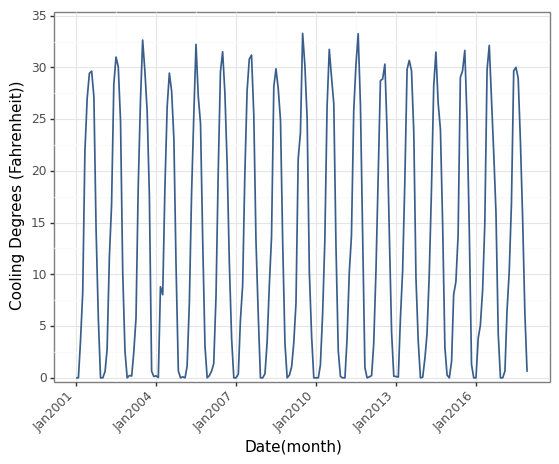

<ggplot: (364603519)>

In [20]:
g1 = (
    ggplot(data=data)
    + geom_line(aes(x="date", y="CLDD_avg"), colour=color[0], size=0.7)
    + labs(x="Date(month)", y="Cooling Degrees (Fahrenheit))")
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 35], breaks=seq(0, 36, 5))
    + scale_x_date(
        breaks=[
            "2001-01-01",
            "2004-01-01",
            "2007-01-01",
            "2010-01-01",
            "2013-01-01",
            "2016-01-01",
        ],
        labels=date_format("%b%Y"),
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1


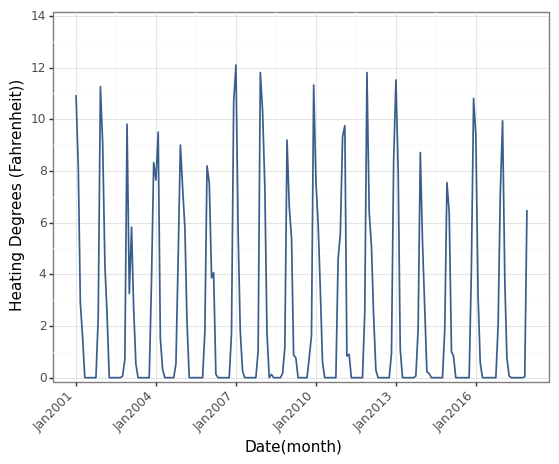

<ggplot: (364700835)>

In [21]:
g1 = (
    ggplot(data=data)
    + geom_line(aes(x="date", y="HTDD_avg"), colour=color[0], size=0.7)
    + labs(x="Date(month)", y="Heating Degrees (Fahrenheit))")
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 14], breaks=seq(0, 15, 2))
    + scale_x_date(
        breaks=[
            "2001-01-01",
            "2004-01-01",
            "2007-01-01",
            "2010-01-01",
            "2013-01-01",
            "2016-01-01",
        ],
        labels=date_format("%b%Y"),
    )
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1


In [22]:
# Serial correlation


In [23]:
for x in ["lnQ", "CLDD_avg", "HTDD_avg", "DX90_avg"]:
    data["D" + x] = data[x] - data[x].shift()


In [24]:
# # functional form investigations (not in textbook)


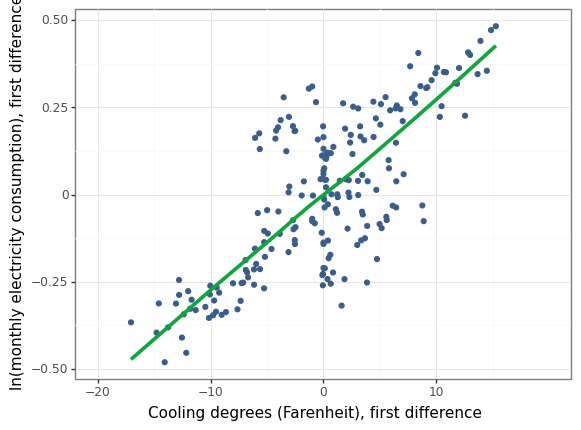

<ggplot: (364479543)>

In [25]:
(
    ggplot(data=data)
    + geom_point(aes(x="DCLDD_avg", y="DlnQ"), fill=color[0], color=color[0])
    + geom_smooth(
        aes(x="DCLDD_avg", y="DlnQ"),
        method="lowess",
        se=False,
        colour=color[1],
        size=1.5,
        span=0.9,
    )
    + labs(
        x="Cooling degrees (Farenheit), first difference",
        y="ln(monthly electricity consumption), first difference",
    )
    + scale_x_continuous(limits=[-20, 20], breaks=seq(-20, 20, 10))
    + theme_bw()
)


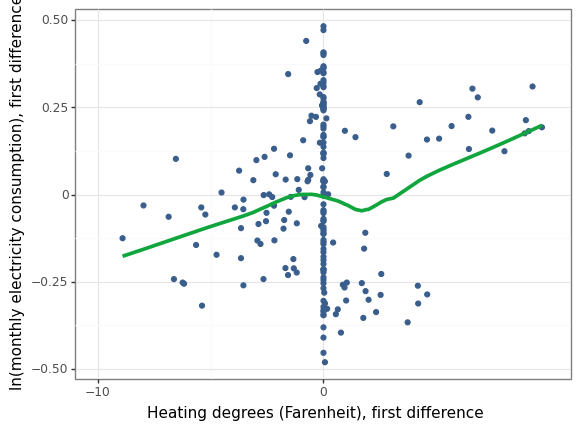

<ggplot: (364658652)>

In [26]:
(
    ggplot(data=data)
    + geom_point(aes(x="DHTDD_avg", y="DlnQ"), fill=color[0], color=color[0])
    + geom_smooth(
        aes(x="DHTDD_avg", y="DlnQ"),
        method="lowess",
        se=False,
        colour=color[1],
        size=1.5,
        span=0.9,
    )
    + labs(
        x="Heating degrees (Farenheit), first difference",
        y="ln(monthly electricity consumption), first difference",
    )
    + scale_x_continuous(limits=[-10, 10], breaks=seq(-10, 10, 10))
    + theme_bw()
)


In [27]:
# Linear regressions


In [28]:
reg1 = (
    smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg", data)
    .fit()
    .get_robustcov_results(cov_type="HAC", maxlags=18)
)
reg2 = (
    smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)", data)
    .fit()
    .get_robustcov_results(cov_type="HAC", maxlags=18)
)


In [29]:
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          3.65e-109
Time:                        12:39:24   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.634      -0.003       0.005
DCLDD_avg      0.0307      0.001     33.658      0.000       0.029       0.032
DHTDD_avg      0.0367      0.003     10.609      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [30]:
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2310.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          1.64e-200
Time:                        12:39:24   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.115      0.000       0.066       0.117
C(month)[T.2]     -0.2740      0.018    -15.446      0.000      -0.309      -0.239
C(month)[T.3]     -0.1219      0.024     -5.009      0.000      -0.170      -0.074
C(month)[T.4]     -0.1837      0.029     -6.427      0.000      -0.240      -0.127
C(month)[T.5]      0.0327      0.013      2.598      0.010       0.008       0.057
C(month)[T.6]      0.0807      0.031      2.621      0.009       0.020       0.141
C(month)[T.7]      0.0580      0.014      4.164      0.000       0.031       0.086
C(month)[T.8]     -0.0854      0.015     -5.689      0.000      -0.115      -0.056
C(month)[T.9]     -0.1757      0.014    -12.491      0.000      -0.203      -0.148
C(month)[T.10]    -0.2464      0.029     -8.472      0.000      -0.304      -0.189
C(month)[T.11]    -0.2418      0.033     -7.424      0.000      -0.306      -0.178
C(month)[T.12]     0.0672      0.022      3.087      0.002       0.024       0.110
DCLDD_avg          0.0169      0.002      7.106      0.000       0.012       0.022
DHTDD_avg          0.0140      0.003      4.155      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [31]:
reg4 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)", data).fit()

reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     281.4
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          4.99e-116
Time:                        12:39:24   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      6.957      0.000       0.066       0.118
C(month)[T.2]     -0.2740      0.018    -15.022      0.000      -0.310      -0.238
C(month)[T.3]     -0.1219      0.019     -6.314      0.000      -0.160      -0.084
C(month)[T.4]     -0.1837      0.019     -9.480      0.000      -0.222      -0.145
C(month)[T.5]      0.0327      0.023      1.418      0.158      -0.013       0.078
C(month)[T.6]      0.0807      0.025      3.244      0.001       0.032       0.130
C(month)[T.7]      0.0580      0.019      3.046      0.003       0.020       0.096
C(month)[T.8]     -0.0854      0.018     -4.673      0.000      -0.121      -0.049
C(month)[T.9]     -0.1757      0.020     -8.985      0.000      -0.214      -0.137
C(month)[T.10]    -0.2464      0.025     -9.806      0.000      -0.296      -0.197
C(month)[T.11]    -0.2418      0.024    -10.004      0.000      -0.289      -0.194
C(month)[T.12]     0.0672      0.026      2.561      0.011       0.015       0.119
DCLDD_avg          0.0169      0.002     10.509      0.000       0.014       0.020
DHTDD_avg          0.0140      0.002      5.902      0.000       0.009       0.019
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
reg4.get_robustcov_results(cov_type="HAC", maxlags=18).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2310.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          1.64e-200
Time:                        12:39:24   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.115      0.000       0.066       0.117
C(month)[T.2]     -0.2740      0.018    -15.446      0.000      -0.309      -0.239
C(month)[T.3]     -0.1219      0.024     -5.009      0.000      -0.170      -0.074
C(month)[T.4]     -0.1837      0.029     -6.427      0.000      -0.240      -0.127
C(month)[T.5]      0.0327      0.013      2.598      0.010       0.008       0.057
C(month)[T.6]      0.0807      0.031      2.621      0.009       0.020       0.141
C(month)[T.7]      0.0580      0.014      4.164      0.000       0.031       0.086
C(month)[T.8]     -0.0854      0.015     -5.689      0.000      -0.115      -0.056
C(month)[T.9]     -0.1757      0.014    -12.491      0.000      -0.203      -0.148
C(month)[T.10]    -0.2464      0.029     -8.472      0.000      -0.304      -0.189
C(month)[T.11]    -0.2418      0.033     -7.424      0.000      -0.306      -0.178
C(month)[T.12]     0.0672      0.022      3.087      0.002       0.024       0.110
DCLDD_avg          0.0169      0.002      7.106      0.000       0.012       0.022
DHTDD_avg          0.0140      0.003      4.155      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [33]:
reg6 = smf.ols("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month) + DlnQ.shift(1)", data).fit()
reg6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          1.29e-114
Time:                        12:39:24   Log-Likelihood:                 320.67
No. Observations:                 202   AIC:                            -611.3
Df Residuals:                     187   BIC:                            -561.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0923      0.018      5.092      0.000       0.057       0.128
C(month)[T.2]     -0.2792      0.020    -13.770      0.000      -0.319      -0.239
C(month)[T.3]     -0.1228      0.031     -3.941      0.000      -0.184      -0.061
C(month)[T.4]     -0.1843      0.022     -8.249      0.000      -0.228      -0.140
C(month)[T.5]      0.0319      0.024      1.304      0.194      -0.016       0.080
C(month)[T.6]      0.0805      0.027      2.936      0.004       0.026       0.135
C(month)[T.7]      0.0582      0.022      2.623      0.009       0.014       0.102
C(month)[T.8]     -0.0854      0.018     -4.673      0.000      -0.121      -0.049
C(month)[T.9]     -0.1761      0.026     -6.746      0.000      -0.228      -0.125
C(month)[T.10]    -0.2470      0.040     -6.197      0.000      -0.326      -0.168
C(month)[T.11]    -0.2427      0.047     -5.176      0.000      -0.335      -0.150
C(month)[T.12]     0.0661      0.040      1.658      0.099      -0.013       0.145
DCLDD_avg          0.0169      0.002      9.584      0.000       0.013       0.020
DHTDD_avg          0.0140      0.002      5.839      0.000       0.009       0.019
DlnQ.shift(1)     -0.0021      0.062     -0.034      0.973      -0.125       0.121
==============================================================================
Omnibus:                        0.182   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.322
Skew:                          -0.043   Prob(JB):                        0.851
Kurtosis:                       2.824   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
reg7 = smf.ols(
    """DlnQ ~ DCLDD_avg + DCLDD_avg.shift(1) +
                          DCLDD_avg.shift(2) +
                          DHTDD_avg + 
                          DHTDD_avg.shift(1) +
                          DHTDD_avg.shift(2) +
                          C(month)""",
    data,
).fit()


In [35]:
stargazer = Stargazer([reg7])
stargazer.covariate_order(
    [
        "DCLDD_avg",
        "DCLDD_avg.shift(1)",
        "DCLDD_avg.shift(2)",
        "DHTDD_avg",
        "DHTDD_avg.shift(1)",
        "DHTDD_avg.shift(2)",
    ]
)
stargazer


In [36]:
data["DDCLDD_avg"] = data["DCLDD_avg"] - data["DCLDD_avg"].shift()
data["DDHTDD_avg"] = data["DHTDD_avg"] - data["DHTDD_avg"].shift()

reg8 = smf.ols(
    """DlnQ ~ DCLDD_avg.shift(2) +
                          DHTDD_avg.shift(2) + 
                          DDCLDD_avg + DDHTDD_avg + 
                          DDCLDD_avg.shift(1) + DDHTDD_avg.shift(1) + 
                          C(month)""",
    data,
).fit()


In [37]:
stargazer = Stargazer([reg8])
stargazer.covariate_order(["DCLDD_avg.shift(2)", "DHTDD_avg.shift(2)"])
stargazer.rename_covariates(
    {
        "DCLDD_avg.shift(2)": "ΔCD cumulative coeff",
        "DHTDD_avg.shift(2)": "ΔHD cumulative coeff",
    }
)
stargazer
